In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time



Using TensorFlow backend.


In [2]:
train_ids = [1,2,3, 7, 8, 9, 10,12,13,14,15,16]
test_ids = [4,5,6,11,17]

In [3]:
dfAll = pd.read_pickle("PklData/df_lstm_norm50.pkl")

In [4]:
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
dfAll['InputMethod'] = dfAll.apply(f, axis=1)
dfAll.TaskID = dfAll.TaskID % 17


In [5]:
df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids)]

df_train2 = df_train[['Blobs', 'TaskID']].copy()
df_test2 = df_test[['Blobs', 'TaskID']].copy()

In [6]:
df2 = dfAll["TaskID"].copy()

In [7]:
h = [i for i in range(17)]

In [8]:
h

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

<BarContainer object of 17 artists>

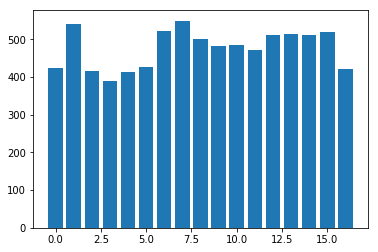

In [9]:
plt.bar(h,dfAll[["userID", "TaskID"]].groupby(["TaskID"])["TaskID"].count())

In [10]:
x_train = np.concatenate(df_train2.Blobs.values).reshape(-1,50,27,15,1)
x_test = np.concatenate(df_test2.Blobs.values).reshape(-1,50,27,15,1)

y_train = df_train2.TaskID.values
y_test = df_test2.TaskID.values


x_train = x_train / 255.0
x_test = x_test / 255.0


In [11]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = len(dfAll.TaskID.unique())
y_train_one_hot = utils.to_categorical(df_train2.TaskID, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.TaskID, num_classes)

In [12]:
num_classes

17

In [13]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allow_growth=True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [14]:
model = load_model("lstm_05_02_19_w50_b50_e1000_.l10001_l20005.h5", compile=False)
    

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 50, 27, 15, 64)    640       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 27, 15, 32)    18464     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 9, 5, 32)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 50, 9, 5, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 50, 9, 5, 32)      9248      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 50, 9, 5, 16)      4624      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 50, 5, 3, 16)      0         
__________

In [ ]:
from keras.utils import plot_model
import pydot
plot_model(model,to_file='demo.pdf',show_shapes=True, show_layer_names=False, rankdir='TB')

In [16]:


y_test_pred = model.predict(x_train, batch_size=50)
y_test_pred = np.argmax(y_test_pred, axis=1)
#model.predict(x_test)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_train, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_train, y_test_pred))


 Summary of the precision, recall, F1 score for each class:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       294
           1       0.94      0.95      0.94       372
           2       0.99      0.93      0.96       278
           3       1.00      0.92      0.96       271
           4       0.98      0.99      0.99       273
           5       0.99      0.98      0.98       285
           6       0.90      1.00      0.95       361
           7       0.96      0.98      0.97       382
           8       1.00      0.93      0.96       360
           9       0.99      0.96      0.97       332
          10       1.00      0.94      0.97       340
          11       1.00      0.95      0.97       327
          12       0.99      0.98      0.98       351
          13       0.91      0.98      0.95       355
          14       0.89      0.98      0.93       351
          15       0.94      0.97      0.96       357
          16       0

In [ ]:

y_test_pred = model.predict(x_test, batch_size=30)
y_test_pred[0] = np.argmax(y_test_pred[0], axis=1)
#model.predict(x_test)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred[0]))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred[0]))